In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        

def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
    

def plot_activations_histogram(encoder, height=1, n_bins=10):
    x_valid_codings = encoder(x_valid).numpy()
    activation_means = x_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, x_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])    

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation='sigmoid'),
])

hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[16]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                   metrics=[rounded_accuracy])

In [5]:
history = hashing_ae.fit(x_train, x_train, epochs=10,
                         validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4066 - rounded_accuracy: 0.8158 - val_loss: 0.3911 - val_rounded_accuracy: 0.8248
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3693 - rounded_accuracy: 0.8489 - val_loss: 0.3734 - val_rounded_accuracy: 0.8386
Epoch 3/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.3578 - rounded_accuracy: 0.8599 - val_loss: 0.3616 - val_rounded_accuracy: 0.8502
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3521 - rounded_accuracy: 0.8654 - val_loss: 0.3560 - val_rounded_accuracy: 0.8615
Epoch 5/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.3484 - rounded_accuracy: 0.8684 - val_loss: 0.3486 - val_rounded_accuracy: 0.8689
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3457 - rounded_accuracy: 0.8715 - val_loss: 0.3450 - val_rounded_accuracy: 0.8769
Epoch 7/10
1719/1719 [============

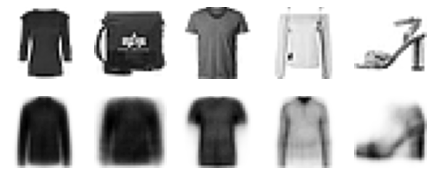

In [6]:
show_reconstructions(hashing_ae)
plt.show()

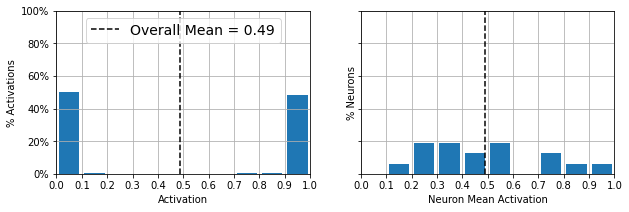

In [7]:
plot_activations_histogram(hashing_encoder)

In [8]:
hashes = np.round(hashing_encoder.predict(x_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100101011011
0000100100111011
0100100100111010
0001100111000010
0001000110110100
...


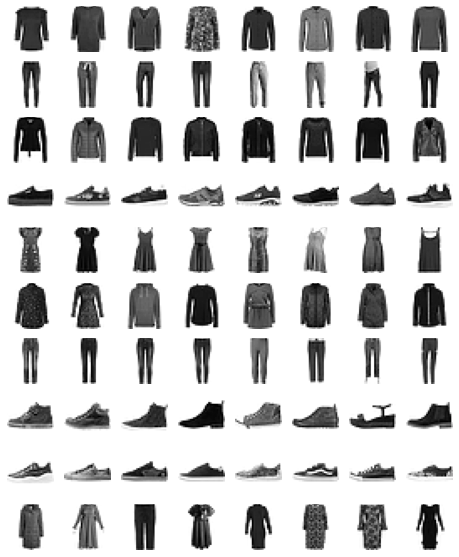

In [9]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(x_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")